In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import sys
import os
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Embedding, Conv1D, GlobalMaxPooling1D
from keras.regularizers import l2
from keras.optimizers import Adam

In [2]:
twitts_train = pd.read_csv("../data/twitter_training.csv")
twitts_valid = pd.read_csv("../data/twitter_validation.csv")

In [3]:
column_name=['tweetID','entity','sentiment','tweet_content']
twitts_train.columns=column_name
twitts_valid.columns=column_name
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# clean the duplicated tweets
twitts_train = twitts_train.drop_duplicates(subset=['tweet_content'])
twitts_valid = twitts_valid.drop_duplicates(subset=['tweet_content'])

# clean the empty tweets
twitts_train = twitts_train.dropna(subset=['tweet_content'])
twitts_valid = twitts_valid.dropna(subset=['tweet_content'])

# lower case the sentiment labels
twitts_train['sentiment'] = twitts_train['sentiment'].str.lower()
twitts_valid['sentiment'] = twitts_valid['sentiment'].str.lower()

# Reset index after cleaning
twitts_train.reset_index(drop=True, inplace=True)
twitts_valid.reset_index(drop=True, inplace=True)

print("Number of tweets in training set after cleaning:", len(twitts_train))
print("Number of tweets in validation set after cleaning:", len(twitts_valid))
# see the  duplicate tweets
print("Number of duplicate tweets in training set:", twitts_train.duplicated().sum())
print("Number of duplicate tweets in validation set:", twitts_valid.duplicated().sum())
# see the nan values
print("Number of nan values in training set:", twitts_train.isnull().sum().sum())
print("Number of nan values in validation set:", twitts_valid.isnull().sum().sum())

# Remove the irrelevant sentiment label
twitts_train = twitts_train[twitts_train['sentiment'].isin(['positive', 'negative', 'neutral'])]
twitts_valid = twitts_valid[twitts_valid['sentiment'].isin(['positive', 'negative', 'neutral'])]


Number of duplicate tweets in training set: 2700
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 686
Number of nan values in validation set: 0
Number of tweets in training set after cleaning: 69490
Number of tweets in validation set after cleaning: 998
Number of duplicate tweets in training set: 0
Number of duplicate tweets in validation set: 0
Number of nan values in training set: 0
Number of nan values in validation set: 0


In [4]:
twitts_train.drop(columns=['tweetID', 'entity'], inplace=True)
twitts_valid.drop(columns=['tweetID', 'entity'], inplace=True)

In [5]:
data = pd.concat([twitts_train, twitts_valid], ignore_index=True)

In [6]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.data_processing import process_tokenize

In [7]:
x=data.drop('sentiment',axis=1)
y=data.sentiment

texts=list(x['tweet_content'])
cleaned_text = [process_tokenize(text) for text in texts]
print(cleaned_text[:10])

[['coming', 'border', 'kill'], ['getting', 'borderland', 'kill'], ['coming', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['getting', 'borderland', 'murder'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'couple', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'picture', 'compared', 'creation', 'made', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'something', 'know', 'huge', 'borderland', 'maya', 'favorite', 'character'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya', 'favorite', 'character', 'decided', 'make', 'wallpaper', 'original', 'image', 'versus', 'creation', 'made', 'enjoy', 'twitter', 'mlsiwfjg'], ['spent', 'hour', 'making', 'something', 'know', 'huge', 'rhandlerr', 'maya

In [8]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(cleaned_text, y, test_size=0.2, random_state=42, stratify=y)


In [9]:
max_vocab = 20000
maxlen = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)

X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

X_train = pad_sequences(X_train_seq, maxlen=maxlen)
X_test = pad_sequences(X_test_seq, maxlen=maxlen)


In [10]:
y_encoder = LabelEncoder()
y_train_enc = y_encoder.fit_transform(y_train)
y_test_enc = y_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)


X_train shape: (46480, 100)
y_train_cat shape: (46480, 3)
X_test shape: (11621, 100)
y_test_cat shape: (11621, 3)


In [11]:
y.value_counts()


sentiment
negative    21432
positive    19342
neutral     17327
Name: count, dtype: int64

In [12]:
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, concatenate
from keras.models import Model

vocab_size = min(max_vocab, len(tokenizer.word_index) + 1)
embedding_dim = 100

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen)(input_layer)

conv3 = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv4 = Conv1D(64, kernel_size=4, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)
conv5 = Conv1D(64, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01))(embedding_layer)

pool3 = GlobalMaxPooling1D()(conv3)
pool4 = GlobalMaxPooling1D()(conv4)
pool5 = GlobalMaxPooling1D()(conv5)

concat = concatenate([pool3, pool4, pool5])

dense = Dense(32, activation='relu', kernel_regularizer=l2(0.05))(concat)
drop = Dropout(0.6)(dense)
output = Dense(3, activation='softmax')(drop)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 64)    │     19,264 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 97, 64)    │     25,664 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 96, 64)    │     32,064 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      6,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │         99 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,083,267 (7.95 MB)

 Trainable params: 2,083,267 (7.95 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=128, validation_data=(X_test, y_test_cat))


Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.3670 - loss: 2.6329 - val_accuracy: 0.3689 - val_loss: 1.0751
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.5229 - loss: 1.0141 - val_accuracy: 0.6133 - val_loss: 0.8403
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6362 - loss: 0.8139 - val_accuracy: 0.6838 - val_loss: 0.7523
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.6877 - loss: 0.7235 - val_accuracy: 0.7296 - val_loss: 0.7043
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7318 - loss: 0.6648 - val_accuracy: 0.7681 - val_loss: 0.6581
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7830 - loss: 0.6130 - val_accuracy: 0.7908 - val_loss: 0.6326
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.8119 - loss: 0.5640 - val_accuracy: 0.8078 - val_loss: 0.5994
Epoch 8/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8322 - loss: 0.5262 - 

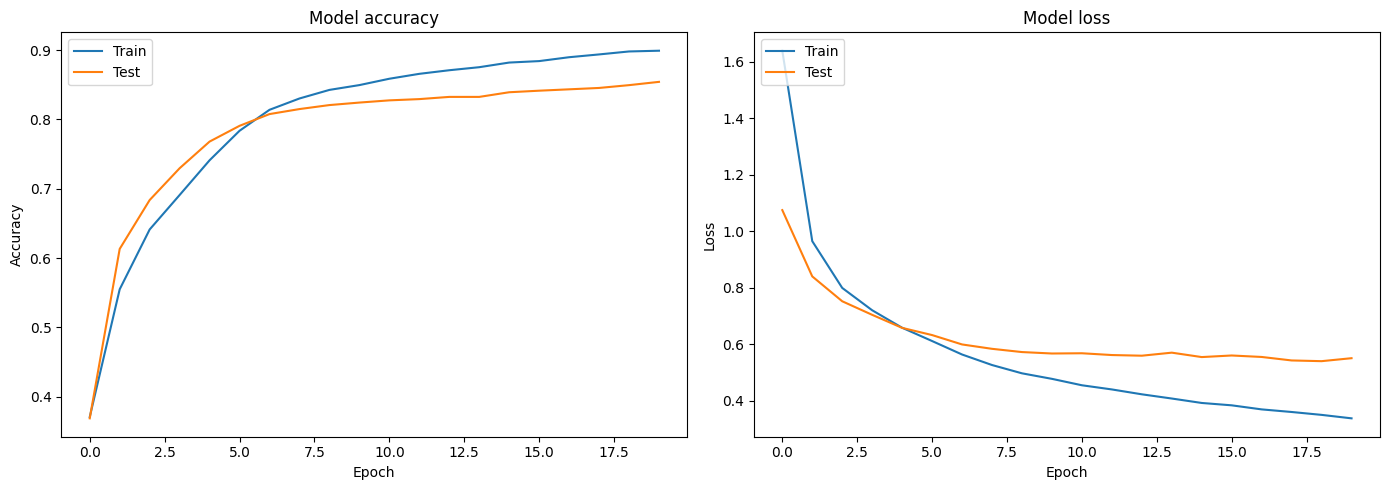

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(['Train', 'Test'], loc='upper left')

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Loss: 0.5506787896156311
Test Accuracy: 0.8542293906211853


364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


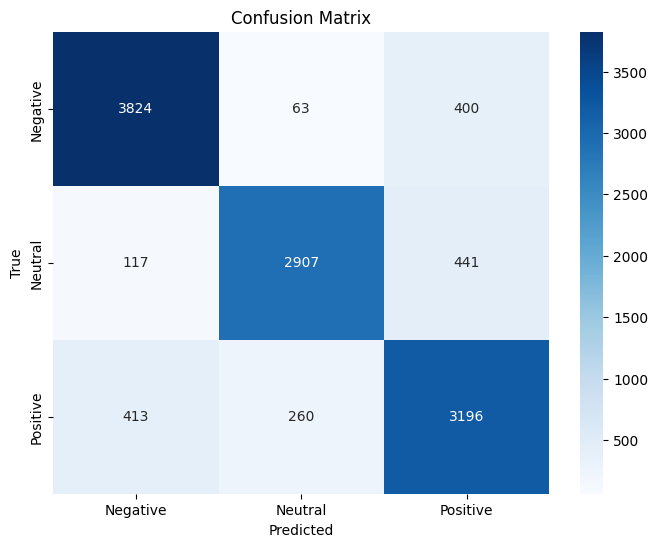

Classification Report:
              precision    recall  f1-score   support

    negative       0.88      0.89      0.89      4287
     neutral       0.90      0.84      0.87      3465
    positive       0.79      0.83      0.81      3869

    accuracy                           0.85     11621
   macro avg       0.86      0.85      0.85     11621
weighted avg       0.86      0.85      0.85     11621



In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# como sei o que representa cada classe?
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=y_encoder.classes_))
